## Controlling for spurious correlation


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import neural_network
from sklearn import gaussian_process
import sklearn.gaussian_process.kernels as gpk
from sklearn.base import clone
import pandas as pd

from typing import NamedTuple

def soft_sign(x):
    s = sigma(x)
    return 2*s - 1.0

def sigma(x):
    return 1.0 / (1.0 + np.exp(-x))

In [2]:
# New way to get data for different ratios of exposure for the top and bottom rows
# zero_shot: hidden_ratio = 1.0, exposed_ratio = 1.0
# cue conflict: hidden_ratio = 1.0, exposed_ratio = 0.0
# partial_exposue: hidden_ratio = 1.0, exposed_ratio = 0.5

class TrainSetting(NamedTuple):
    rho0: float
    rho1: float

def setting_to_name(setting):
    return f'rho0_{setting.rho0}__rho1_{setting.rho1}'

def exact_corr(rho0, rho1):
    p = (rho0 + rho1)/2.0
    q = np.abs((rho0 - rho1)/2.0)
    return q/np.sqrt(p*(1.0-p))


def find_rho(rho0, corr):
    xx = np.linspace(0.001, 0.999, num = 500)
    temp_corr = lambda x: np.abs(exact_corr(x, rho0))
    diff = np.abs(temp_corr(xx) - corr)
    return xx[np.argmin(diff)]
 
# rhos going from PE towards full exposure
towards_full = [[1.0, 0.5], [0.99, 0.5], [0.9, 0.5]]

# the corresponding spurious correlation levels
corrs_tf = [np.round(exact_corr(x, y), 5) for x, y in towards_full]

# match corrs_tf but instead interpolating towards zero shot
zs_matched_rho0s = [np.round(find_rho(1.0, x), 2) for x in corrs_tf]
towards_zs = [[1.0, x] for x in zs_matched_rho0s]

# find rho1s that correspond to towards_full rho0s but match PE surious correlation
tf_rho0s = [x for x, y in towards_full]
tf_matched_rho1s = [np.round(find_rho(x, exact_corr(0.0, 0.5)), 2) for x in tf_rho0s]
tf_matched = [[x, y] for x, y in zip(tf_rho0s, tf_matched_rho1s)]

all_points = towards_zs + towards_full[1:] + tf_matched[1:]

SETTINGS = tuple([TrainSetting(x, y) for x, y in all_points])
corrs = [exact_corr(x, y) for x, y in all_points]

for setting, corr in zip(SETTINGS, corrs): print(setting, ' spurious corr: %0.3f'% corr)

TrainSetting(rho0=1.0, rho1=0.5)  spurious corr: 0.577
TrainSetting(rho0=1.0, rho1=0.52)  spurious corr: 0.562
TrainSetting(rho0=1.0, rho1=0.68)  spurious corr: 0.436
TrainSetting(rho0=0.99, rho1=0.5)  spurious corr: 0.562
TrainSetting(rho0=0.9, rho1=0.5)  spurious corr: 0.436
TrainSetting(rho0=0.99, rho1=0.48)  spurious corr: 0.578
TrainSetting(rho0=0.9, rho1=0.34)  spurious corr: 0.577


In [3]:
def get_correlated_data(
    settings = SETTINGS,
    x_offset_abs: float = 3.0,
    y_offset_abs: float = 3.0,
    num_datapoints: int = 300,
    center_value: float = 0.0 ):

    inf_dim = 1
    distractor_dim = 0

    test_true_label = 0
    test_distractor_label = 1


    # generate data
    data_list = []
    for x in [-x_offset_abs, x_offset_abs]:
        for y in [-y_offset_abs, y_offset_abs]:
            center = center_value + np.array([x, y])[None, :]
            data_list.append(
              center
              + np.reshape(np.random.normal(size=num_datapoints * 2), (-1, 2))
            )

    data = np.concatenate(data_list, axis=0)

    # classify the data
    true_label = (data[:, inf_dim] > center_value).astype("int")

    # track confounder values
    distractor_label = (data[:, distractor_dim] > center_value).astype("int")

    # denote labels by whether they are same as test set or not
    true_label_eq2test = true_label == test_true_label
    distractor_label_eq2test = distractor_label == test_distractor_label
    
    # For ease, we do away with train - test split, and test might inlcude some train points
    mask = np.logical_and(true_label_eq2test, distractor_label_eq2test)
    test_x, test_y = data[mask], true_label[mask]
        
    datas = []
    
    for setting in settings:
        
#         print("new setting")
        # start with none included
        mask =  true_label > 100
        rho0, rho1 = setting.rho0, setting.rho1
        
        # data with same true label and same distractor
        mask_quad = np.logical_and(true_label_eq2test, distractor_label_eq2test)
        mask_subsample = np.random.uniform(size=4 * num_datapoints) > rho0
        
        mask_temp = np.logical_and(mask_quad, mask_subsample)
        mask = np.logical_or(mask, mask_temp)
        
#         print(sum(mask_quad), sum(mask_subsample), sum(mask_temp), sum(mask))
        
        
        # data with same true label as test but different distractor
        mask_quad = np.logical_and(
          true_label_eq2test, np.logical_not(distractor_label_eq2test)
        )
        mask_subsample = np.random.uniform(size=4 * num_datapoints) < rho0
        
        mask_temp = np.logical_and(mask_quad, mask_subsample)
        mask = np.logical_or(mask, mask_temp)
        
#         print(sum(mask_quad), sum(mask_subsample), sum(mask_temp), sum(mask))
        
        # data with different true label but same distractor
        mask_quad = np.logical_and(np.logical_not(true_label_eq2test), distractor_label_eq2test)
        mask_subsample = np.random.uniform(size=4 * num_datapoints) > rho1
        
        mask_temp = np.logical_and(mask_quad, mask_subsample)
        mask = np.logical_or(mask, mask_temp)
        
#         print(sum(mask_quad), sum(mask_subsample), sum(mask_temp), sum(mask))
        
        
        # data with different true label as test and different distractor
        mask_quad = np.logical_and(
          np.logical_not(true_label_eq2test), np.logical_not(distractor_label_eq2test)
        )
        mask_subsample = np.random.uniform(size=4 * num_datapoints) < rho1
        
        mask_temp = np.logical_and(mask_quad, mask_subsample)
        mask = np.logical_or(mask, mask_temp)
        
#         print(sum(mask_quad), sum(mask_subsample), sum(mask_temp), sum(mask))
        
        # mask finalized
        mask = mask.flatten()
        
        train_x0, train_y0 = data[mask], true_label[mask]
    
        shuffle = np.random.permutation(len(train_y0))

        train_x, train_y = train_x0[shuffle], train_y0[shuffle]

        ds = {
          "train": {'inp': train_x,
                    'label': train_y},
          "test": {'inp': test_x,
                   'label': test_y},
          "setting": setting
        }
        datas.append(ds)       
        coef = np.corrcoef(true_label[mask], distractor_label[mask])
#         print('coefficient: ', coef[0, 1])
    
    
    
        
    return datas
        
        

In [4]:
d = get_correlated_data()
print(len(d))


7


In [35]:
plt_size = 10

def classify_data(data, clf):
    clf.fit(data['inp'], data['label'])

    xx = np.linspace(-plt_size, plt_size)
    l_x = xx.shape[0]
    X, Y = np.meshgrid(xx, xx)
    inp = np.concatenate((X[:, :, None], Y[:,:, None]), axis = 2)
    pred = clf.predict(inp.reshape((-1, 2))).reshape(l_x, l_x)
    
#     pred = (inp.reshape((-1, 2))[:, 1] < 0).reshape(l_x, l_x)

    return clf, pred

def plot(ax, data, pred, name, legend = False):
    #test_true_label set to 1 above
    feps = data['train']['inp'][data['train']['label'] == 0]
    blickets = data['train']['inp'][data['train']['label'] == 1]
    
    xx = np.linspace(-plt_size, plt_size)
    X, Y = np.meshgrid(xx, xx)

    
    if ax: 
        
        if 'kernel' in name: 
            alpha = 0.99
        else: 
            alpha = 0.3
        
        ax.contourf(X, Y, 1.0 - pred, alpha = alpha)
        if legend: 
            ax.scatter(data['test']['inp'][:, 0], data['test']['inp'][:, 1], 
                   s = 20, facecolors = 'white', label = 'Test blickets' if legend else None) 
            ax.scatter(feps[:, 0], feps[:, 1], 
                   s = 20, facecolors = 'tab:green', label = 'Train feps' if legend else None)
            ax.scatter(blickets[:, 0], blickets[:, 1], 
                   s = 20, facecolors = 'tab:purple', label = 'Train blickets' if legend else None)
        ax.set_xticks(np.arange(-plt_size, plt_size+1, step=plt_size/2))
        ax.set_yticks(np.arange(-plt_size, plt_size+1, step=plt_size/2))
        ax.set_title(name)
#         if legend: ax.legend()
        
    return ax



    
def bar_results(means, stds, ax):
    
    ax.bar(np.arange(len(means)) + 1, means, yerr = stds)
    ax.set_ylim([-0.1, 1.1])
    
    return ax
    

In [36]:
def run_analyses(reps = 10, clfs = None, resample_data = False, fname = None, makefig = True):
    if clfs is None: clfs = [(linear_model.RidgeClassifier(), 'logreg'), 
                         (linear_model.LogisticRegression(), 'ridgereg')]
    
    if fname is None: fname = str(int(np.random.uniform()*100000))
    datas = get_correlated_data()
    cols = ['seed', 'expt', 'rho0', 'rho1', 'classifier', 'train_perf', 'test_perf']
    perf_df = pd.DataFrame(columns = cols)
    with open(fname + '.csv', 'w') as f:
        f.write(', '.join(cols) + '\n')
    counter = 0
    for i in np.arange(reps):
        verbose = not i
        print('copy:', i)
        if resample_data:
            datas = get_correlated_data()
        for j, clf_tuple in enumerate(clfs):
            clf, clf_name = clf_tuple
            for k, data in enumerate(datas): 
                
                if verbose: print(i, clf, setting_to_name(data['setting']))
                cond_perf = []

                c, pred = classify_data(data['train'], clf = clone(clf))
                train_perf = np.mean(c.predict(data['train']['inp']) == data['train']['label'])
                test_perf = np.mean(c.predict(data['test']['inp']) == data['test']['label'])
                row = [
                    i, 
                    setting_to_name(data['setting']),
                    data['setting'].rho0,
                    data['setting'].rho1,
                    clf_name, 
                    train_perf,
                    test_perf
                ]
                perf_df.loc[counter] = row
                with open(fname + '.csv', 'a') as f:
                    row = [str(x) for x in row]
                    f.write(', '.join(row) + '\n')
                counter += 1


    # eliminate those that don't get good train perf
    perf_df = perf_df[perf_df['train_perf'] > 0.95]
    summ = perf_df.groupby(['expt', 'classifier']).agg(['mean', 'sem']).reset_index()
    summ.columns = ['_'.join(col).strip() for col in summ.columns.values]

    return perf_df


In [39]:
clfs = [
    (linear_model.LogisticRegression(), 'logreg'),
    
    (gaussian_process.GaussianProcessClassifier(kernel = gpk.RBF(),
                                               max_iter_predict = 20), 'gauss_kernel'),
    
    
    (neural_network.MLPClassifier(hidden_layer_sizes = (5,), 
                                 activation = 'relu',
                                 max_iter=2000), 'MLP_5H_1L')
 ]
    

In [41]:
d = run_analyses(reps = 100, clfs = clfs, fname = 'all_rho_settings', resample_data=True, makefig = False)

copy: 0
0 LogisticRegression() rho0_1.0__rho1_0.5
0 LogisticRegression() rho0_1.0__rho1_0.52
0 LogisticRegression() rho0_1.0__rho1_0.68
0 LogisticRegression() rho0_0.99__rho1_0.5
0 LogisticRegression() rho0_0.9__rho1_0.5
0 LogisticRegression() rho0_0.99__rho1_0.48
0 LogisticRegression() rho0_0.9__rho1_0.34
0 GaussianProcessClassifier(kernel=RBF(length_scale=1), max_iter_predict=20) rho0_1.0__rho1_0.5
0 GaussianProcessClassifier(kernel=RBF(length_scale=1), max_iter_predict=20) rho0_1.0__rho1_0.52
0 GaussianProcessClassifier(kernel=RBF(length_scale=1), max_iter_predict=20) rho0_1.0__rho1_0.68
0 GaussianProcessClassifier(kernel=RBF(length_scale=1), max_iter_predict=20) rho0_0.99__rho1_0.5
0 GaussianProcessClassifier(kernel=RBF(length_scale=1), max_iter_predict=20) rho0_0.9__rho1_0.5
0 GaussianProcessClassifier(kernel=RBF(length_scale=1), max_iter_predict=20) rho0_0.99__rho1_0.48
0 GaussianProcessClassifier(kernel=RBF(length_scale=1), max_iter_predict=20) rho0_0.9__rho1_0.34
0 MLPClassifie

## Correlation analyses plot

In [45]:
# rhos tested in rebuttal: [[0.0, 0.5], [0.1/1.1, 0.5], [0.25/1.25, 0.5], [0.5, 0.5]]
# [0.0, 0.5] = partial exposure

towards_full = [[0.0, 0.5], [0.09, 0.5], [0.2, 0.5], [0.5, 0.5]]
corrs_tf = [np.round(exact_corr(x, y), 5) for x, y in towards_full]

# match corrs_tf but instead interpolating towards zero shot
zs_matched_rho0s = [np.round(find_rho(0.0, x), 2) for x in corrs_tf]
towards_zs = [[0.0, x] for x in zs_matched_rho0s]

## matching spurious correlations
# find rho1s that correspond to towards_full rho0s but match PE surious correlation
tf_rho0s = [x for x, y in towards_full]
tf_matched_rho1s = [np.round(find_rho(x, exact_corr(0.0, 0.5)), 2) for x in tf_rho0s]
tf_matched = [[x, y] for x, y in zip(tf_rho0s, tf_matched_rho1s)]

# # find rho1s that correspond to towards_zs rho1s but match PE surious correlation
# zs_rho1s = [y for x, y in towards_zs]
# zs_matched_rho0s = [np.round(find_rho(x, exact_corr(0.0, 0.5)), 2) for x in zs_rho1s]
# zs_matched = [[x, y] for x, y in zip(zs_matched_rho0s, zs_rho1s)]

# all_matched = zs_matched + tf_matched



<ipython-input-40-3b7a8be6f5cd>:5: RuntimeWarning: invalid value encountered in true_divide
  return q/np.sqrt(p*(1.0-p))


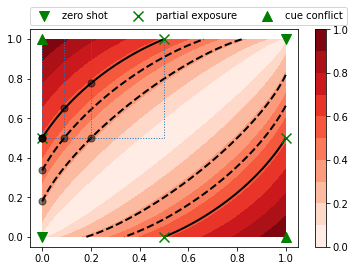

In [46]:
xx = np.linspace(0.00, 1.0, num = 500)
l_x = xx.shape[0]
X, Y = np.meshgrid(xx, xx)
corrs = exact_corr(X, Y)
plt.contour(X, Y,corrs,levels = [0.57735], colors=('k',),linestyles=('-',),linewidths=(2,))
plt.contour(X, Y,corrs,levels = corrs_tf[::-1][:-1], colors=('k',),linestyles=('--',),linewidths=(2,))
plt.contourf(X, Y,corrs, levels = np.arange(11)/10.0, cmap = 'Reds')
plt.colorbar()

plt.vlines(tf_rho0s, 0.5, 1.0, linestyles=(':',),linewidths=(1,))
plt.hlines(0.5, 0.0, 0.5, linestyles=(':',),linewidths=(1,))

ZS = np.array([[0.0, 0.0], [1.0, 1.0]])
PE = np.array([[0.0, 0.5], [1.0, 0.5], [0.5, 0.0], [0.5, 1.0]])
CC = np.array([[0.0, 1.0], [1.0, 0.0]])
plt.scatter(ZS[:, 0], ZS[:, 1], s = 100, c = 'g', marker = 'v', zorder = 3, label = 'zero shot')
plt.scatter(PE[:, 0], PE[:, 1], s = 100, c = 'g', marker = 'x', zorder = 3, label = 'partial exposure')
plt.scatter(CC[:, 0], CC[:, 1], s = 100, c = 'g', marker = '^', zorder = 3, label = 'cue conflict')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=3,borderaxespad=0.)

points = np.array(towards_zs[:-1] + towards_full[:-1] + tf_matched[:-1])
plt.scatter(points[:, 0], points[:, 1], s = 50, c = 'k', zorder = 3, alpha = 0.5)
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)

plt.show()